# Proyecto 1 - Explorando los Algoritmos de Aprendizaje Supervisado
## Juan Ignacio Navarro, Jose David Sánchez y Steven Badilla

### Implementación de los algoritmos de aprendizaje supervisado


#### Regresión Logística

In [928]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

class OurLogisticRegression:
    """ Logistic Regression model using numpy"""

    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        """
        Model constructor
        Inputs:
        lr -> learning rate
        num_iter -> number of iterations in model
        """
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {"lr": self.lr, "num_iter": self.num_iter}
    
    def set_params(self, **params):
        """
        Set the model hyperparameters
        """
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        """
        Activation function sigmoid
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Training function that changes the w and b values progressively using
        descend gradient
        """
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        """
        Predict probability given by the model using sigmoid function
        """
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        """
        Get the result the prediction of a set of data by comparing the threshold
        """
        return self.predict_prob(X) >= threshold
    
    def score(self, X, y):
        """
        Score the values obtained
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    # model metrics

    def accurancy(self, y_pred,y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

#### Árboles de decisión

In [929]:
# Auxiliar functions

def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    if c1== 0 or c2 == 0:  
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

def get_entropy(y_predict, y_real):
    """
    Getting the whole entropy
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

class OurDecisionTreeClassifier(object):
    """ Decision Tree model using numpy """

    def __init__(self, max_depth=5):
        """
        Model constructor
        Inputs:
        max_depth -> maximum depth of the classifier tree
        """
        self.depth = 0
        self.max_depth = max_depth

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {"max_depth": self.max_depth}
    
    def set_params(self, **params):
        """
        Set de model hyperparameters
        """
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, x, y, par_node={}, depth=0):
        """
        Training function that generates the tree progressively by using the
        entropy
        """
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': features[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    #all features versus values, get best
    def find_best_split_of_all(self, x, y):
        """
        Get the best values that can split the dataset with 
        the lower entropoy possible
        """
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_best_split(self, col, y):
        """
        Calculate the entropy of only one feature
        """
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value #get which ones are less than
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        """
        Predict the category of a series of values
        """
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        try:
            while cur_layer.get('cutoff'):
                if row[cur_layer['index_col']] < cur_layer['cutoff']:
                    cur_layer = cur_layer['left']
                else:
                    cur_layer = cur_layer['right']
            else:
                return cur_layer.get('val')
        except:
            return 0.0
    
    def score(self, X, y):
        """
        Score the values obtained
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    # model metrics
        
    def accurancy(self, y_pred, y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

#### KNN

In [930]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

class OurKNearestNeighbors():
    """ K-nearest neighbors model using numpy"""

    def __init__(self, n_neighbors=2):
        """
        Model constructor
        Inputs:
        n_neighbors -> the amount of neighbors to consider in the model
        """
        self.X_train = 0.0
        self.y_train = 0.0

        self.n_neighbors = n_neighbors

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {'n_neighbors': self.n_neighbors}

    def set_params(self, **parameters):
        """
        Set the model hyperparameters
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def minkowski_distance(self, a, b, p=10):
        return np.power(np.sum(np.power(np.abs(a - b), p), axis=1), 1/p)

    def kneighbors(self, X_test):
        """
        get the closest data from a test dataset
        """
        dist = []
        neigh_ind = []
        point_dist = []

        for x_test in X_test:
            point_dist += [ self.minkowski_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        return np.array(neigh_ind)

    def predict(self, X_test):
        """
        Cathegorize the test dataset based nearest neighbors values
        """
        neighbors = self.kneighbors(X_test)
        y_pred = np.array([
            np.argmax(np.bincount(self.y_train[neighbor]))
            for neighbor in neighbors
        ])
        return y_pred

    def score(self, X_test, y_test):
        """
        Score the obtained values
        """
        y_pred = self.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        return accuracy

    # model metrics

    def accurancy(self, y_pred,y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
        
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

### Prueba de los algoritmos con set de datos



#### Set de datos de Red Wine Quality

In [931]:
# read the data set
df_wine = pd.read_csv('datasets/winequality-red.csv')

# make sure that there are no null values that can affect the models
mask = df_wine.isnull()
#print(mask.sum())

# visualizing the values of each feature and the comparison to the output
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
l_limit_perc = 0.01
h_limit_perc = 0.99

for feature in features:
    low_limit = df_wine[feature].quantile(l_limit_perc)
    high_limit = df_wine[feature].quantile(h_limit_perc)
    df_wine = df_wine.loc[(df_wine[feature] >= low_limit) & (df_wine[feature] <= high_limit)]

# visualizing the new values
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# feature engineering
# normalization of the data
for feature in features:
    df_wine[feature] = (df_wine[feature]-df_wine[feature].mean())/df_wine[feature].std()

# change the value of the output to only two values
# 0 -> bad wine, wines with 3, 4 and 5 in quality
# 1 -> good wine, wines with 6, 7 and 8 in queality
df_wine.loc[df_wine['quality'] <= 5, 'quality'] = 0
df_wine.loc[df_wine['quality'] > 5, 'quality'] = 1

# Define training and test sets using stratify
X0 = df_wine.loc[df_wine['quality'] == 0, features]
Y0 = df_wine.loc[df_wine['quality'] == 0, 'quality']

X1 = df_wine.loc[df_wine['quality'] == 1, features]
Y1 = df_wine.loc[df_wine['quality'] == 1, 'quality']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
1,-0.304938,2.161772,-1.411229,0.207560,0.571559,1.031186,0.767153,0.024570,-0.872713,0.332310,-0.574418,0
2,-0.304938,1.427003,-1.193394,-0.118582,0.337264,-0.047882,0.324934,0.154124,-0.418407,0.089543,-0.574418,0
3,1.907741,-1.512074,1.638460,-0.553438,-0.326572,0.167932,0.529035,0.801895,-1.175584,-0.476915,-0.574418,1
4,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
5,-0.565253,0.814695,-1.411229,-0.662152,-0.326572,-0.263696,-0.151302,0.672341,1.474535,-0.638760,-1.000675,0
6,-0.239859,0.447311,-1.084476,-0.879580,-0.560867,-0.047882,0.495018,-0.234539,-0.115536,-1.447985,-1.000675,0
8,-0.304938,0.324849,-1.302311,-0.444724,-0.404670,-0.695323,-0.899674,0.024570,0.338770,-0.557837,-0.894111,1
9,-0.500174,-0.164997,0.549286,4.012548,-0.482768,0.167932,1.957744,0.672341,0.263052,1.303380,0.171531,0
10,-1.020805,0.324849,-0.975559,-0.662152,0.532510,-0.047882,0.699120,-0.558425,-0.266972,-0.800605,-1.213804,0


#####    -> Prueba con Regresión Logística

Best hyperparameters:  {'lr': 0.001, 'num_iter': 100}
    Tests    Model  Accurancy  Precision    Recall       Auc
0      25     Ours   0.760000   0.760000  0.760000  0.760000
1      25  Sklearn   0.800000   0.800000  0.800000  0.800000
2      63     Ours   0.761905   0.753846  0.777778  0.761905
3      63  Sklearn   0.777778   0.753623  0.825397  0.777778
4     126     Ours   0.742063   0.732824  0.761905  0.742063
5     126  Sklearn   0.753968   0.735294  0.793651  0.753968
6     189     Ours   0.735450   0.740541  0.724868  0.735450
7     189  Sklearn   0.732804   0.720000  0.761905  0.732804
8     226     Ours   0.716814   0.718750  0.712389  0.716814
9     226  Sklearn   0.730088   0.714876  0.765487  0.730088
10    252     Ours   0.722222   0.727642  0.710317  0.722222
11    252  Sklearn   0.736111   0.722846  0.765873  0.736111


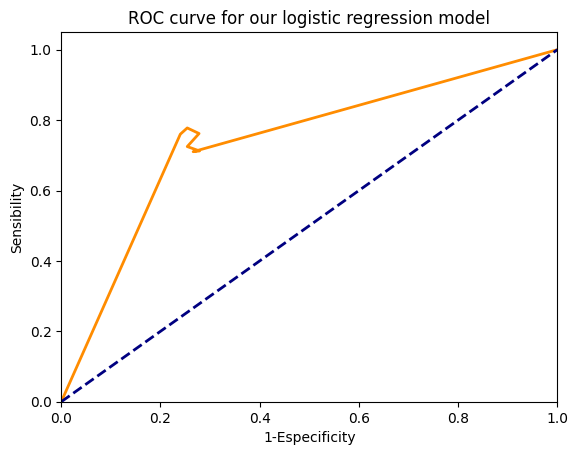

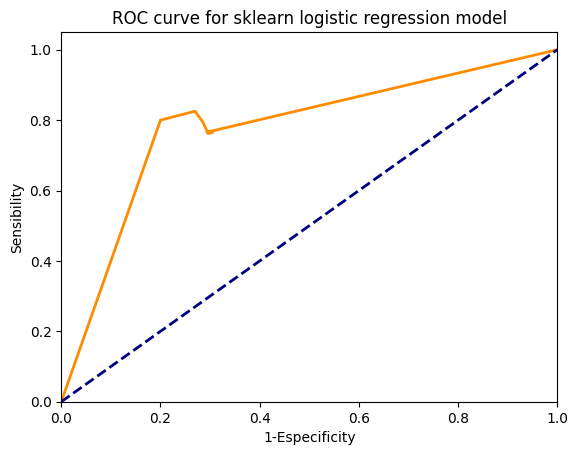

In [932]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurLogisticRegression()
param_grid = {'lr': [0.001, 0.05, 0.01],
              'num_iter': [100, 1000, 10000]}
grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurLogisticRegression(lr=0.001, num_iter=100)
model.fit(X_train, y_train)

# Instantiate sklearn logistic regression model
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict probabilities for test set
    probs = model.predict_prob(X_test_i)

    # predict classes for test set
    y_pred_i = model.predict(X_test_i, 0.5)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

    

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Red-Wine-Quality-Logistic-Regression.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')


#####    -> Prueba con Árbol de Decisión

Best hyperparameters:  {'max_depth': 7}
    Tests    Model  Accurancy  Precision    Recall       Auc
0      25     Ours   0.720000   0.923077  0.480000  0.720000
1      25  Sklearn   0.640000   0.620690  0.720000  0.640000
2      63     Ours   0.666667   0.818182  0.428571  0.666667
3      63  Sklearn   0.666667   0.643836  0.746032  0.666667
4     126     Ours   0.650794   0.839286  0.373016  0.650794
5     126  Sklearn   0.674603   0.652778  0.746032  0.674603
6     189     Ours   0.621693   0.767442  0.349206  0.621693
7     189  Sklearn   0.650794   0.637681  0.698413  0.650794
8     226     Ours   0.615044   0.760000  0.336283  0.615044
9     226  Sklearn   0.659292   0.646341  0.703540  0.659292
10    252     Ours   0.613095   0.761468  0.329365  0.613095
11    252  Sklearn   0.672619   0.658182  0.718254  0.672619


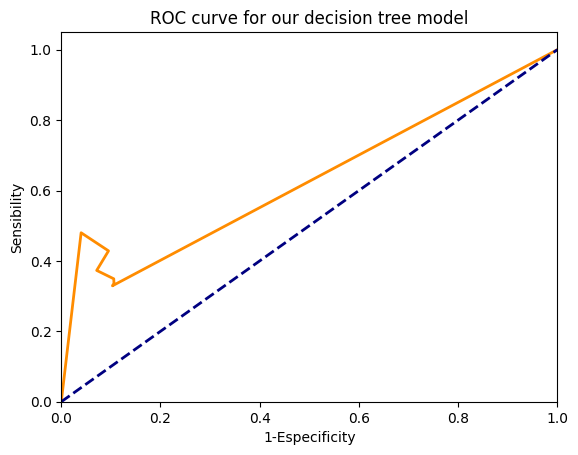

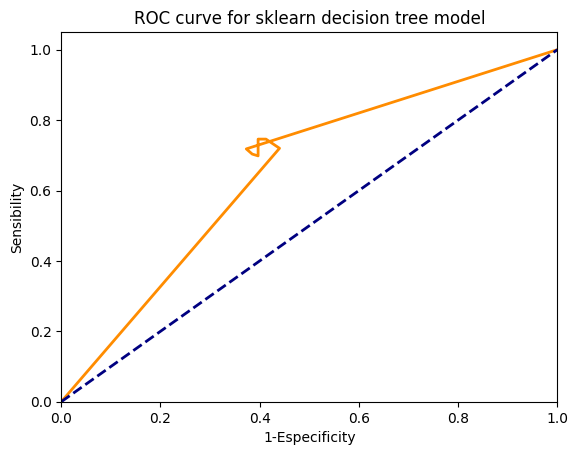

In [933]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurDecisionTreeClassifier()
param_grid = {'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train.values, y_train.values)
print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurDecisionTreeClassifier(max_depth=7)
model.fit(x=X_train.values, y=y_train.values)

# Instantiate sklearn logistic regression model
model_sklearn = DecisionTreeClassifier()


model_sklearn.fit(X_train, y_train.astype('int'))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i.values.astype(int))
    y_tests['sklearn_model'].append(y_test_i.values.astype(int))

    # predict classes for test set
    y_pred_i = model.predict(X_test_i.values)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))


# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)


# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Red-Wine-Quality-Decision-Tree.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our decision tree model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn decision tree model')

#####    -> Prueba con KNN

Best hyperparameters:  {'n_neighbors': 5}
    Tests    Model  Accurancy  Precision    Recall       Auc
0      25     Ours   0.640000   0.629630  0.680000  0.640000
1      25  Sklearn   0.640000   0.629630  0.680000  0.640000
2      63     Ours   0.650794   0.617284  0.793651  0.650794
3      63  Sklearn   0.706349   0.671053  0.809524  0.706349
4     126     Ours   0.654762   0.622642  0.785714  0.654762
5     126  Sklearn   0.690476   0.662162  0.777778  0.690476
6     189     Ours   0.640212   0.612766  0.761905  0.640212
7     189  Sklearn   0.666667   0.643836  0.746032  0.666667
8     226     Ours   0.650442   0.622302  0.765487  0.650442
9     226  Sklearn   0.665929   0.643678  0.743363  0.665929
10    252     Ours   0.660714   0.633663  0.761905  0.660714
11    252  Sklearn   0.668651   0.647059  0.742063  0.668651


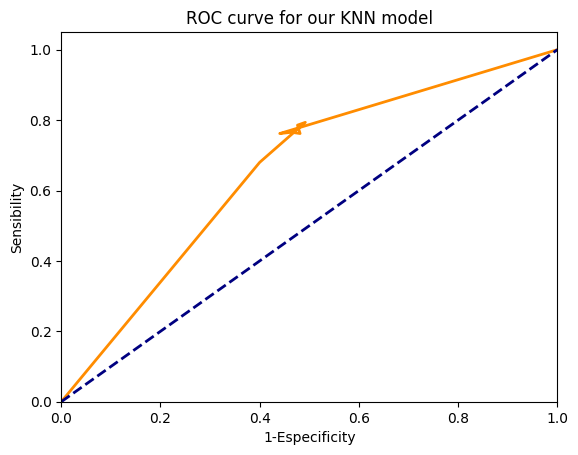

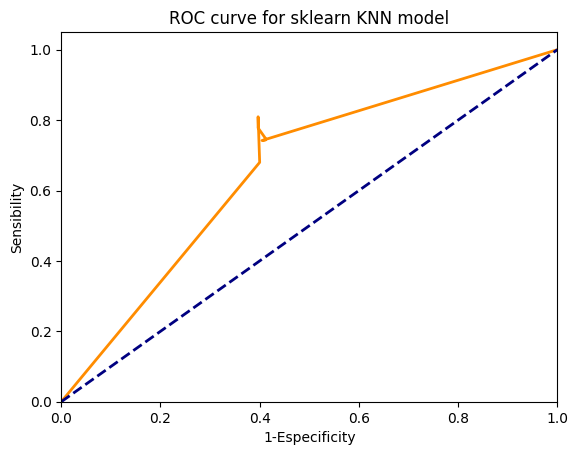

In [934]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the best model hyperparameters
model = OurKNearestNeighbors()
param_grid = {'n_neighbors': [5, 7, 9, 11, 15, 25, 30, 35, 40]}
grid_search = GridSearchCV(model, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train.values, y_train.values)

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
k = 5
model = OurKNearestNeighbors(k)
model.fit(X_train, y_train)

model_sklearn = KNeighborsClassifier(n_neighbors=k)
model_sklearn.fit(X_train, y_train)

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict classes for test set
    if isinstance(X_test_i, pd.DataFrame):
        X_test_i = X_test_i.to_numpy()
        
    y_pred_i = model.predict(X_test_i)
    y_pred_i = pd.DataFrame(y_pred_i)

    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Red-Wine-Quality-KNN.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our KNN model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn KNN model')

#### Set de datos de notas del curso de Arquitectura de Computadores I

In [935]:
# read first data set
df_2021_s1_grades = pd.read_csv('datasets/2021-s1.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2021_s1_grades.isnull()
#print(mask.sum())

df_2021_s1_grades = df_2021_s1_grades.drop('Tarea 2 Entrega 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Proyecto Individual Viernes 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Proyecto Individual Lunes 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Exposición', axis=1)

# Arranging cols
col_Investi = df_2021_s1_grades.pop('Total: Investigación 5.0%')  # Cut col
df_2021_s1_grades.insert(14, 'Total: Investigación 5.0%', col_Investi)  # Insert col

In [936]:
# read second data set
df_2021_s2_grades = pd.read_csv('datasets/2021-s2.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2021_s2_grades.isnull()
#print(mask.sum())

df_2021_s2_grades = df_2021_s2_grades.drop('Examen 2 Práctico Ext 0.25%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Proyecto Individual Entrega V 0.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Proyecto Individual Entrega M 0.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Entrega', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 1', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 2', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 3', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 4', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Total: Extra 2.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Total: Extra 5 noviembre 1.0%', axis=1)

In [937]:
# read third data set
df_2022_s1_grades = pd.read_csv('datasets/2022-s1.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2022_s1_grades.isnull()
#print(mask.sum())

# delete students from robot project (only 6 in the whole data set)
df_2022_s1_grades = df_2022_s1_grades.drop([0, 4, 10, 20, 22, 26]) 

df_2022_s1_grades = df_2022_s1_grades.drop('Tarea 1 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Individual Entrega V 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Individual Entrega L 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grupal 2 Anteproyecto 1.75%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grup 2 Funcional Rob 11.38%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grupal 2 Docu Robot 4.37%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Entrega 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Evaluación 5.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Evaluación', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Total: Puntaje extra 2%', axis=1)

# Arranging cols
col_Tarea2 = df_2022_s1_grades.pop('Tarea 2 3.75%')  # Cut col
df_2022_s1_grades.insert(5, 'Tarea 2 3.75%', col_Tarea2)  # Insert col

In [938]:
# read fourth data set
df_2022_s2_grades = pd.read_csv('datasets/2022-s2.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2022_s2_grades.isnull()
#print(mask.sum())

df_2022_s2_grades = df_2022_s2_grades.drop('Examen parcial 2 práctico repo 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Examen parcial 2 prác rep eval 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Tarea 2 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 2 Anteproyecto 1.75%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 1 Func Eval 13.12%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 1 Docu Eval 4.38%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Entrega', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Charla 1 Simics 0.5%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Charla 2 Ronald 0.5%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Taller Simics 2%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Extra proyecto 1.75%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Total: Extra 4.75%', axis=1)

In [939]:
# Merging four datasets frames into one frame

df_2021_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
df_2022_s1_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
df_2022_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)

df_arqui = pd.concat([df_2021_s1_grades, df_2021_s2_grades, df_2022_s1_grades, df_2022_s2_grades], axis=0, ignore_index=True)

df_arqui.replace(r'^\s*$', np.nan,regex=True, inplace=True)
df_arqui.fillna(0.0, inplace=True)
df_arqui = df_arqui.drop('Final', axis=1)


# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['Examen 1 15.0%', 
            'Examen 2 Práctico 5.0%', 
            'Examen 2 Teórico 10.0%', 
            'Total: Exámenes 30.0%', 
            'Tarea 1 3.75%', 
            'Tarea 2 Evaluación 3.75%', 
            'Total: Tareas 7.5%', 
            'Proyecto Individual Docu 3.75%', 
            'Proyecto Individual Funcional 11.25%', 
            'Proyecto Grupal 1 Funcional 13.12%',
            'Proyecto Grupal 1 Docu 4.38%',
            'Proyecto Grupal 2 Funcional 13.12%',
            'Proyecto Grupal 2 Docu 4.38%',
            'Total: Proyectos 50.0%',
            'Total: Investigación 5.0%',
            'Taller 1',
            'Taller 2',
            'Taller 3',
            'Taller 4',
            'Taller 5',
            'Total: Taller 7.5%']

l_limit_perc = 0.01
h_limit_perc = 0.99

df_arqui = df_arqui.astype(float)

for feature in features:
    low_limit = df_arqui[feature].quantile(l_limit_perc)
    high_limit = df_arqui[feature].quantile(h_limit_perc)
    df_arqui = df_arqui.loc[(df_arqui[feature] >= low_limit) & (df_arqui[feature] <= high_limit)]

# feature engineering
# normalization of the data
for feature in features:
    df_arqui[feature] = (df_arqui[feature]-df_arqui[feature].mean())/df_arqui[feature].std()

# change the value of the output to only two values
# 0 -> Student failed, less than 67.5 as final grade
# 1 -> Student passed, great or equal than 67.5 as final grade
df_arqui.loc[df_arqui['Total: '] <= 67.5, 'Total: '] = 0
df_arqui.loc[df_arqui['Total: '] > 67.5, 'Total: '] = 1

# Define training and test sets using stratify
X0 = df_arqui.loc[df_arqui['Total: '] == 0, features]
Y0 = df_arqui.loc[df_arqui['Total: '] == 0, 'Total: ']

X1 = df_arqui.loc[df_arqui['Total: '] == 1, features]
Y1 = df_arqui.loc[df_arqui['Total: '] == 1, 'Total: ']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_arqui.head(5)

/tmp/ipykernel_346490/2703026304.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2021_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
/tmp/ipykernel_346490/2703026304.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022_s1_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
/tmp/ipykernel_346490/2703026304.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)


,Examen 1 15.0%,Examen 2 Práctico 5.0%,Examen 2 Teórico 10.0%,Total: Exámenes 30.0%,Tarea 1 3.75%,Tarea 2 Evaluación 3.75%,Total: Tareas 7.5%,Proyecto Individual Docu 3.75%,Proyecto Individual Funcional 11.25%,Proyecto Grupal 1 Funcional 13.12%,...,Proyecto Grupal 2 Docu 4.38%,Total: Proyectos 50.0%,Total: Investigación 5.0%,Taller 1,Taller 2,Taller 3,Taller 4,Taller 5,Total: Taller 7.5%,Total:
0,0.608534,-1.162069,-0.030399,-0.009979,0.823093,0.603086,0.835132,0.052219,1.151204,1.187786,...,0.188374,0.915790,0.544830,0.232150,0.852475,0.727088,-1.480341,1.074001,0.168250,1.0
1,-1.326258,-1.542372,-1.588984,-1.771099,-1.234709,-2.077296,-1.943578,-1.923581,-1.802788,-2.087235,...,-1.928273,-2.074044,-1.890585,-0.995520,-1.750624,-1.751650,-1.480341,-1.060796,-1.804104,0.0
2,0.432644,1.360705,0.236939,1.700783,1.472926,-2.077296,-0.364765,0.642393,1.151204,-0.613475,...,0.188374,0.353150,0.544830,0.845984,0.852475,0.727088,0.799638,-1.060796,0.284271,1.0
3,-1.925235,-1.542372,-1.588984,-2.035476,-1.234709,-2.077296,-1.943578,-1.923581,-1.802788,-2.087235,...,-1.928273,-2.074044,-1.890585,-2.223189,-1.750624,-1.751650,-1.480341,-1.060796,-2.036146,0.0
4,1.003098,-1.542372,-0.030399,0.072551,0.571283,0.603086,0.687776,0.642393,1.151204,1.187786,...,0.188374,0.968904,0.544830,0.845984,0.852475,-0.841953,0.799638,1.074001,0.496976,1.0


#####    -> Prueba con Regresión Logística

Best hyperparameters:  {'lr': 0.05, 'num_iter': 10000}
    Tests    Model  Accurancy  Precision    Recall       Auc
0       1     Ours   1.000000   1.000000  1.000000  1.000000
1       1  Sklearn   1.000000   1.000000  1.000000  1.000000
2       3     Ours   1.000000   1.000000  1.000000  1.000000
3       3  Sklearn   1.000000   1.000000  1.000000  1.000000
4       6     Ours   1.000000   1.000000  1.000000  1.000000
5       6  Sklearn   1.000000   1.000000  1.000000  1.000000
6       9     Ours   0.944444   1.000000  0.888889  0.944444
7       9  Sklearn   1.000000   1.000000  1.000000  1.000000
8      11     Ours   0.909091   0.909091  0.909091  0.909091
9      11  Sklearn   1.000000   1.000000  1.000000  1.000000
10     13     Ours   0.923077   0.923077  0.923077  0.923077
11     13  Sklearn   1.000000   1.000000  1.000000  1.000000


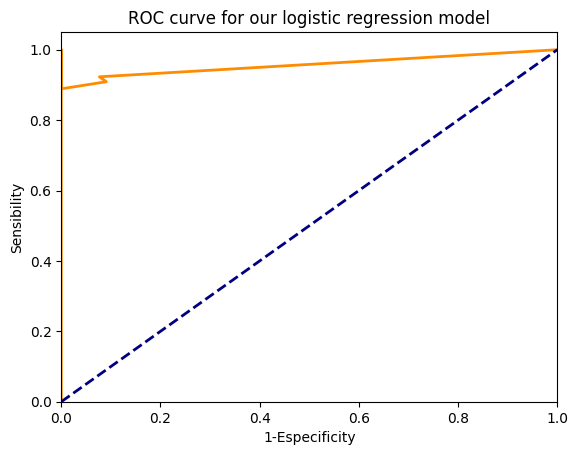

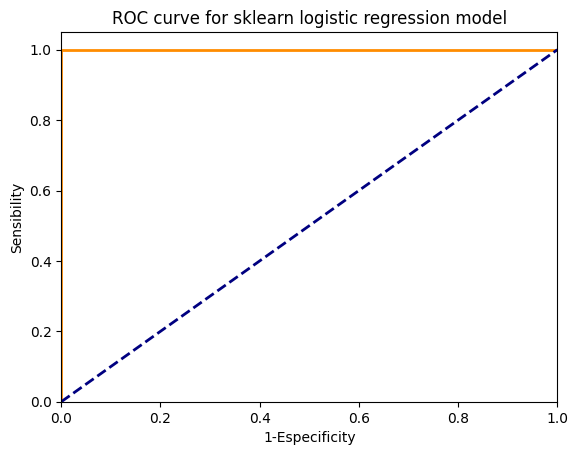

In [940]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurLogisticRegression()
param_grid = {'lr': [0.001, 0.05, 0.01],
              'num_iter': [100, 1000, 10000]}
grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurLogisticRegression(lr=0.001, num_iter=100)
model.fit(X_train, y_train)

# Instantiate sklearn logistic regression model
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict probabilities for test set
    probs = model.predict_prob(X_test_i)

    # predict classes for test set
    y_pred_i = model.predict(X_test_i, 0.5)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Architecture1-Logistic-Regression.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')

#####    -> Prueba con Árbol de Decisión

Best hyperparameters:  {'max_depth': 5}
    Tests    Model  Accurancy  Precision  Recall       Auc
0       1     Ours   1.000000   1.000000     1.0  1.000000
1       1  Sklearn   1.000000   1.000000     1.0  1.000000
2       3     Ours   1.000000   1.000000     1.0  1.000000
3       3  Sklearn   1.000000   1.000000     1.0  1.000000
4       6     Ours   1.000000   1.000000     1.0  1.000000
5       6  Sklearn   1.000000   1.000000     1.0  1.000000
6       9     Ours   1.000000   1.000000     1.0  1.000000
7       9  Sklearn   0.944444   0.900000     1.0  0.944444
8      11     Ours   1.000000   1.000000     1.0  1.000000
9      11  Sklearn   0.954545   0.916667     1.0  0.954545
10     13     Ours   1.000000   1.000000     1.0  1.000000
11     13  Sklearn   0.961538   0.928571     1.0  0.961538


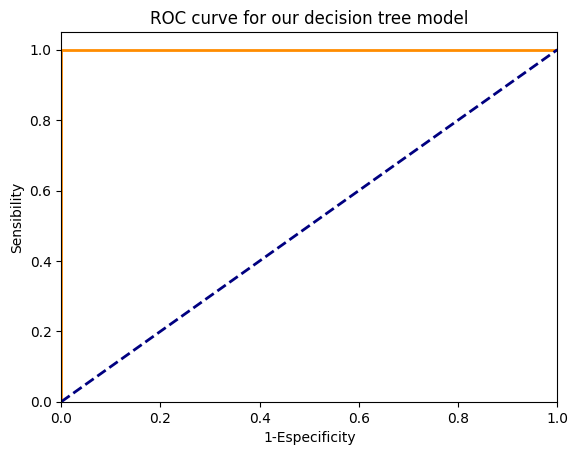

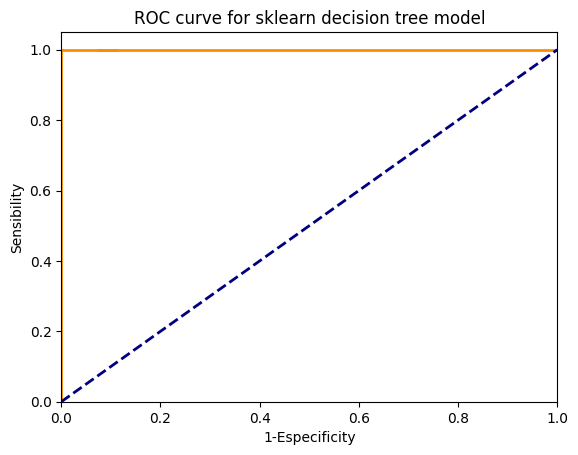

In [941]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurDecisionTreeClassifier()
param_grid = {'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train.values, y_train.values)
print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurDecisionTreeClassifier(max_depth=7)
model.fit(x=X_train.values, y=y_train.values)

# Instantiate sklearn logistic regression model
model_sklearn = DecisionTreeClassifier()


model_sklearn.fit(X_train, y_train.astype('int'))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i.values.astype(int))
    y_tests['sklearn_model'].append(y_test_i.values.astype(int))

    # predict classes for test set
    y_pred_i = model.predict(X_test_i.values)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))


# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Architecture1-Decision-Tree.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our decision tree model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn decision tree model')

#####    -> Prueba con KNN

Best hyperparameters:  {'n_neighbors': 5}
    Tests    Model  Accurancy  Precision  Recall       Auc
0       1     Ours   1.000000   1.000000     1.0  1.000000
1       1  Sklearn   1.000000   1.000000     1.0  1.000000
2       3     Ours   1.000000   1.000000     1.0  1.000000
3       3  Sklearn   1.000000   1.000000     1.0  1.000000
4       6     Ours   1.000000   1.000000     1.0  1.000000
5       6  Sklearn   1.000000   1.000000     1.0  1.000000
6       9     Ours   1.000000   1.000000     1.0  1.000000
7       9  Sklearn   1.000000   1.000000     1.0  1.000000
8      11     Ours   0.954545   0.916667     1.0  0.954545
9      11  Sklearn   0.954545   0.916667     1.0  0.954545
10     13     Ours   0.961538   0.928571     1.0  0.961538
11     13  Sklearn   0.961538   0.928571     1.0  0.961538


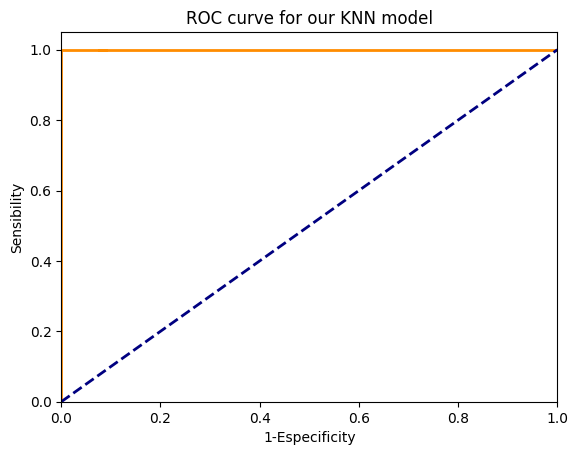

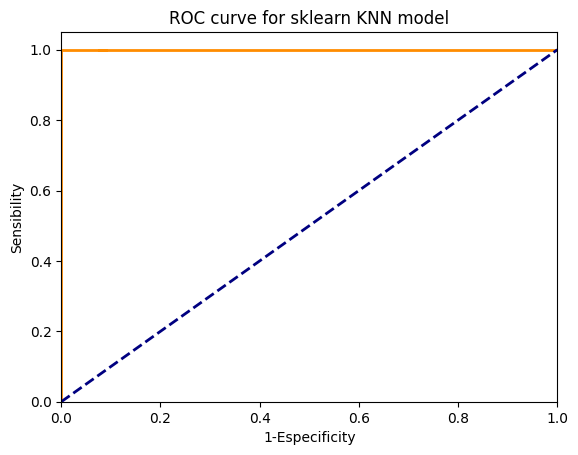

In [942]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the best model hyperparameters
model = OurKNearestNeighbors()
param_grid = {'n_neighbors': [5, 7, 9, 11, 15, 25, 30, 35, 40]}
grid_search = GridSearchCV(model, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train.values, y_train.values.astype(int))

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
k = 5
model = OurKNearestNeighbors(k)
model.fit(X_train, y_train.astype(int))

model_sklearn = KNeighborsClassifier(n_neighbors=k)
model_sklearn.fit(X_train, y_train)

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict classes for test set
    if isinstance(X_test_i, pd.DataFrame):
        X_test_i = X_test_i.to_numpy()
        
    y_pred_i = model.predict(X_test_i)
    y_pred_i = pd.DataFrame(y_pred_i)

    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Architecture1-KNN.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our KNN model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn KNN model')

#### Set de datos a elegir - Cancer Dataset

In [943]:
# read the dataset
df_cancer = pd.read_csv('datasets/Cancer_Data.csv')

# make sure that there are no null values that can affect the models
mask = df_cancer.isnull()
#print(mask.sum())

# delete unnecesary or null columns
df_cancer = df_cancer.drop(columns=['id', 'Unnamed: 32'])

# visualizing the values of each feature and the comparison to the output
"""
for col in df_cancer.columns[:-1]:
    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
plt.show()
"""

# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
l_limit_perc = 0
h_limit_perc = 0.99

for feature in features:
    low_limit = df_cancer[feature].quantile(l_limit_perc)
    high_limit = df_cancer[feature].quantile(h_limit_perc)
    df_cancer = df_cancer.loc[(df_cancer[feature] >= low_limit) & (df_cancer[feature] <= high_limit)]

# visualizing the new values
# (not ploting to avoid data overload in the notebook)
"""
for col in df_cancer.columns[:-1]:
    df_cancer.plot(x=col, y='diagnosis', kind='scatter', figsize=(8, 5))
plt.show()
"""

# feature engineering
# normalization of the data
for feature in features:
    df_cancer[feature] = (df_cancer[feature]-df_cancer[feature].mean())/df_cancer[feature].std()

# change value of output to 0 and 1
# 0 -> B
# 1 -> M
df_cancer.loc[df_cancer['diagnosis'] == 'B', 'diagnosis'] = 0
df_cancer.loc[df_cancer['diagnosis'] == 'M', 'diagnosis'] = 1

# Define training and test sets using stratify
X0 = df_cancer.loc[df_cancer['diagnosis'] == 0, features]
Y0 = df_cancer.loc[df_cancer['diagnosis'] == 0, 'diagnosis']

X1 = df_cancer.loc[df_cancer['diagnosis'] == 1, features]
Y1 = df_cancer.loc[df_cancer['diagnosis'] == 1, 'diagnosis']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_cancer.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
4,1,2.693059,-1.066016,2.804659,3.153238,0.570109,1.450598,2.910960,2.638141,0.316256,...,2.292792,-1.448454,2.441541,2.564984,0.495124,0.049978,1.478654,1.462551,-0.956138,-0.161961
6,1,1.907110,0.414335,1.922237,2.044515,0.108663,0.738427,1.135330,1.478698,0.245176,...,2.395693,0.584415,2.486269,2.657834,0.844900,0.590506,1.319582,2.103252,0.706127,0.437678
10,1,1.047960,1.269999,0.960112,0.999640,-0.914330,-0.527622,-0.523937,-0.081384,-1.015293,...,1.278912,1.734956,1.171264,1.292044,-0.497623,-0.462804,-0.392655,0.152977,0.432650,0.510677
11,1,0.955495,-0.134235,1.011350,0.927163,0.309681,1.342875,0.861388,1.174870,0.472630,...,1.651173,0.514125,1.739310,1.738322,0.608287,3.707276,1.452879,1.848641,2.439734,2.273095
13,1,0.982464,1.456356,1.017043,0.934497,-0.755632,0.475103,0.858057,0.699614,0.496323,...,0.567683,0.584415,0.643472,0.472871,-0.754811,-0.079502,0.242898,0.406544,0.102099,-1.370799
16,1,0.531699,0.453706,0.506946,0.510853,0.437453,-0.368730,0.328699,0.659435,-0.740454,...,1.242594,1.180033,1.153372,1.256103,0.958063,-0.133966,0.678874,1.429160,0.625273,0.305583
17,1,1.090339,0.598067,1.267537,1.003954,1.929216,3.527266,2.373900,2.580743,1.998461,...,1.814604,1.291017,1.752728,1.786244,2.629788,2.293272,2.056028,2.397515,2.235220,3.089994
19,0,0.092492,-1.060767,0.092492,0.000926,0.365836,-0.090744,0.176532,0.476526,0.676390,...,0.044098,-0.969370,0.093317,-0.022228,0.834613,-0.234672,0.292976,0.759242,0.501614,-0.526090
20,0,-0.084732,-0.706427,-0.011690,-0.198817,1.156071,1.277044,-0.259778,-0.162890,1.064956,...,-0.140519,-0.741852,-0.068151,-0.263937,0.176211,0.796030,-0.075247,-0.408836,0.993872,0.276905
21,0,-1.462455,-1.564716,-1.451461,-1.260516,0.741014,-0.580586,-0.595336,-0.558554,0.344687,...,-1.432837,-1.635279,-1.452932,-1.209207,0.237936,-0.876935,-0.814123,-0.629220,-0.751625,-0.079402


#####    -> Prueba con Regresión Logística

Best hyperparameters:  {'lr': 0.05, 'num_iter': 10000}
    Tests    Model  Accurancy  Precision    Recall       Auc
0       3     Ours   0.833333   1.000000  0.666667  0.833333
1       3  Sklearn   0.833333   1.000000  0.666667  0.833333
2       9     Ours   0.833333   0.800000  0.888889  0.833333
3       9  Sklearn   0.833333   1.000000  0.666667  0.833333
4      19     Ours   0.921053   0.900000  0.947368  0.921053
5      19  Sklearn   0.894737   1.000000  0.789474  0.894737
6      28     Ours   0.910714   0.870968  0.964286  0.910714
7      28  Sklearn   0.910714   1.000000  0.821429  0.910714
8      34     Ours   0.911765   0.868421  0.970588  0.911765
9      34  Sklearn   0.926471   1.000000  0.852941  0.926471
10     38     Ours   0.907895   0.860465  0.973684  0.907895
11     38  Sklearn   0.921053   1.000000  0.842105  0.921053


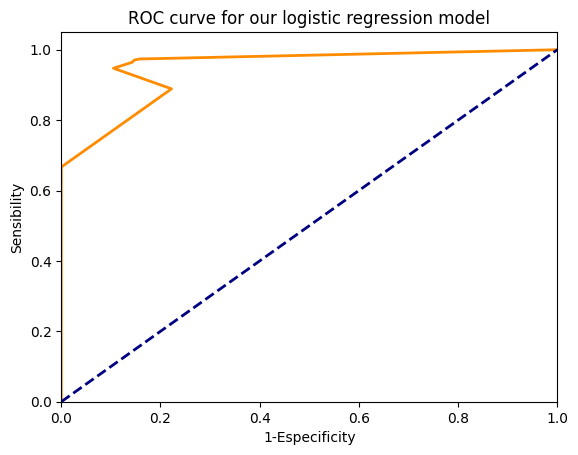

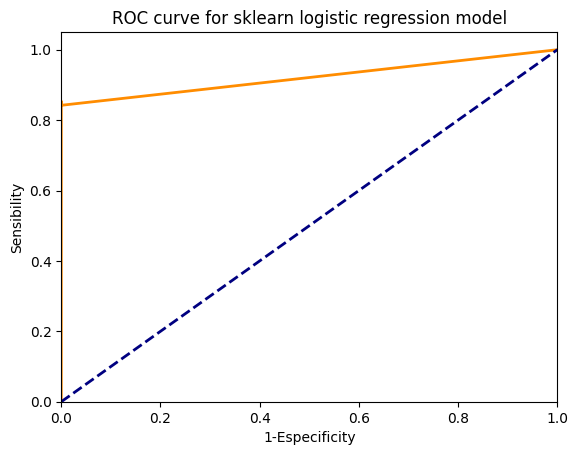

In [944]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurLogisticRegression()
param_grid = {'lr': [0.001, 0.05, 0.01],
              'num_iter': [100, 1000, 10000]}
grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, y_train.astype(int))

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurLogisticRegression(lr=0.001, num_iter=100)
model.fit(X_train, y_train.astype(int))

# Instantiate sklearn logistic regression model
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train.astype(int))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict probabilities for test set
    probs = model.predict_prob(X_test_i)

    # predict classes for test set
    y_pred_i = model.predict(X_test_i, 0.5)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i].astype(int))
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i].astype(int))
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Cancer-Logistic-Regression.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')


#####    -> Prueba con Árbol de Decisión

Best hyperparameters:  {'max_depth': 5}
    Tests    Model  Accurancy  Precision    Recall       Auc
0       3     Ours   0.833333   1.000000  0.666667  0.833333
1       3  Sklearn   0.833333   1.000000  0.666667  0.833333
2       9     Ours   0.888889   1.000000  0.777778  0.888889
3       9  Sklearn   0.888889   1.000000  0.777778  0.888889
4      19     Ours   0.868421   1.000000  0.736842  0.868421
5      19  Sklearn   0.921053   1.000000  0.842105  0.921053
6      28     Ours   0.875000   0.956522  0.785714  0.875000
7      28  Sklearn   0.946429   1.000000  0.892857  0.946429
8      34     Ours   0.852941   0.928571  0.764706  0.852941
9      34  Sklearn   0.941176   0.968750  0.911765  0.941176
10     38     Ours   0.855263   0.935484  0.763158  0.855263
11     38  Sklearn   0.934211   0.971429  0.894737  0.934211


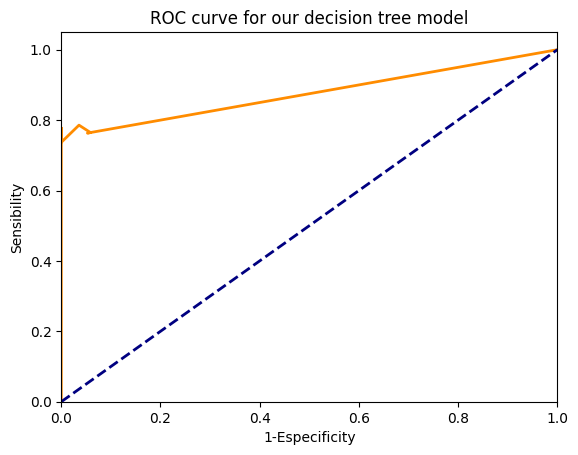

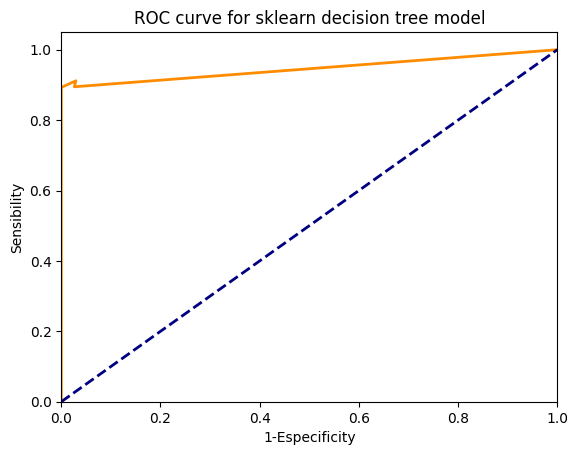

In [945]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurDecisionTreeClassifier()
param_grid = {'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train.values, y_train.values)
print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurDecisionTreeClassifier(max_depth=5)
model.fit(x=X_train.values, y=y_train.values)

# Instantiate sklearn logistic regression model
model_sklearn = DecisionTreeClassifier()


model_sklearn.fit(X_train, y_train.astype('int'))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i.values.astype(int))
    y_tests['sklearn_model'].append(y_test_i.values.astype(int))

    # predict classes for test set
    y_pred_i = model.predict(X_test_i.values)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))


# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

    

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Cancer-Decision-Tree.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our decision tree model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn decision tree model')

#####    -> Prueba con KNN

Best hyperparameters:  {'n_neighbors': 5}
    Tests    Model  Accurancy  Precision    Recall       Auc
0       3     Ours   0.833333        1.0  0.666667  0.833333
1       3  Sklearn   0.833333        1.0  0.666667  0.833333
2       9     Ours   0.888889        1.0  0.777778  0.888889
3       9  Sklearn   0.944444        1.0  0.888889  0.944444
4      19     Ours   0.894737        1.0  0.789474  0.894737
5      19  Sklearn   0.868421        1.0  0.736842  0.868421
6      28     Ours   0.892857        1.0  0.785714  0.892857
7      28  Sklearn   0.910714        1.0  0.821429  0.910714
8      34     Ours   0.897059        1.0  0.794118  0.897059
9      34  Sklearn   0.911765        1.0  0.823529  0.911765
10     38     Ours   0.881579        1.0  0.763158  0.881579
11     38  Sklearn   0.907895        1.0  0.815789  0.907895


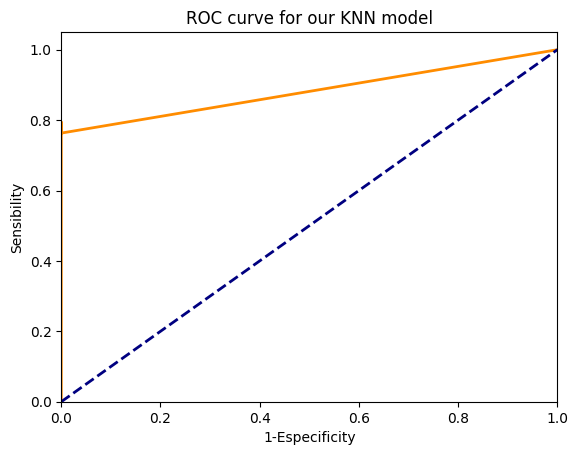

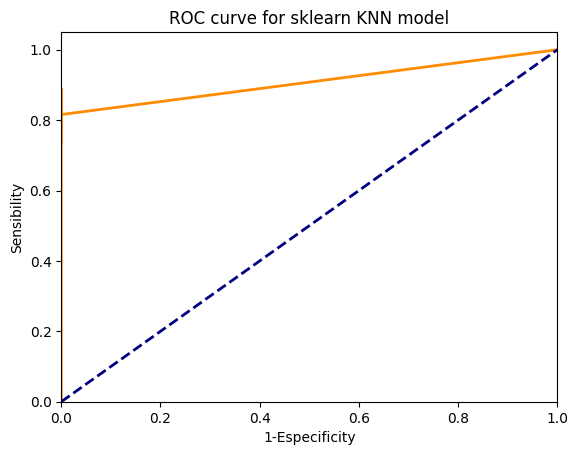

In [946]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the best model hyperparameters
model = OurKNearestNeighbors()
param_grid = {'n_neighbors': [5, 7, 9, 11, 15, 25, 30, 35, 40]}
grid_search = GridSearchCV(model, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train.values, y_train.values.astype(int))

print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
k = 5
model = OurKNearestNeighbors(k)
model.fit(X_train, y_train.astype(int))

model_sklearn = KNeighborsClassifier(n_neighbors=k)
model_sklearn.fit(X_train, y_train.astype(int))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i)
    y_tests['sklearn_model'].append(y_test_i)

    ## Predictions for out model
    # predict classes for test set
    if isinstance(X_test_i, pd.DataFrame):
        X_test_i = X_test_i.to_numpy()
        
    y_pred_i = model.predict(X_test_i)
    y_pred_i = pd.DataFrame(y_pred_i)

    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.astype(int)))

# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i].astype(int))
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i].astype(int))
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

# display test metric results
title_row = ['Tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Ours', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
df_results = df_results.round(3)
df_results.to_csv('results/Cancer-KNN.csv', index=False)

model.plot_roc(fpr_model, tpr_model, 'ROC curve for our KNN model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn KNN model')

### Puntos extra: modelo que precide la nota del estudiante (utilizando el set de datos de Arquitectura de Computadores I)

La predicción está basada en las notas del proyecto 1, proyecto 2, examen 1 y taller 1.